# Prepare ERA5 data for Jon's model

Predictor: Geopotential at 500 hPa (z500):
- regrid to 5.625 degree resolution
- calculate anomalies

Predictor: Blocking index:
- based on PV blocks (Schwierz et al. 2014)
- fraction of blocked grid cells in 8 regions: Greenland [-60°E, -30°E], Atlantic [-30°E, 0°], Europe [0°, 30°E], Russia [30°E, 60°E]
  - further divided into North (55°-75°N) and South (35°-55°N)
- Notebook is on the GIUB climcal server 

Target: Surface temperature (t2m):
- only grids over land (mask out ocean)
- calculate anomalies

Info:
- Anomalies are calculated with respect to a running mean window of length `31 days` to remove the seasonal cycle.

To do:
- Remove trend?




## Z500

In [58]:
# import packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [47]:
# Load data
DATADIR = '/home/steidani/windows/data/ParetoBoost/'  # Location of ERA5 dataset at 1.875° resolution, hourly from 1979 to 2021
data = xr.open_mfdataset(f'{DATADIR}z500/geopotential_500*.nc', combine='by_coords')

In [48]:
# We regrid the data to a lower resolution for faster computation and rename latitude/longitude to lat/lon

resol =  5.625 # 22 x 11 grid over NA/Europe

import collections.abc
#xesmf needs the following aliases, otherwise it will not work
collections.Iterable = collections.abc.Iterable
import xesmf as xe

if 'latitude' in data.coords:
    data = data.rename({'latitude': 'lat', 'longitude': 'lon'})

# Create output grid
grid_out = xr.Dataset(
    {
        'lat': (['lat'], np.arange(30, 90, resol)),
        'lon': (['lon'], np.arange(-60, 60, resol)),
    }
)

# Create regridder
regridder = xe.Regridder(
    data, grid_out, 'bilinear', periodic=True,
    )

data = regridder(data)

In [49]:
# daily mean
data = data.resample(time='1D').mean()

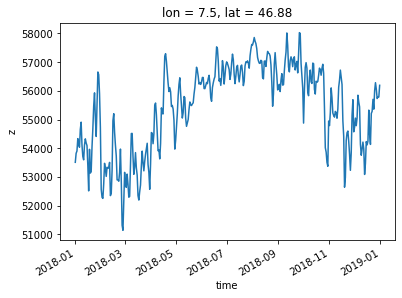

In [50]:
data.z.sel(lon=7.5, lat=46.875, time="2018").plot()

In [51]:
# running window
window = 31
groupby = "dayofyear"

# mean
data_mean = data.sel(time=slice("1979-01-01", "2000-12-31")).groupby('time' + '.' + groupby).mean('time')
data_mean = data_mean.chunk({'dayofyear': None})
# add periodicity
data_mean = data_mean.pad(**{groupby:window}, mode='wrap')
# rolling mean
data_mean = data_mean.rolling(**{groupby:window}, center=True).mean()
# remove periodicity
data_mean = data_mean.isel(**{groupby:slice(window,-window)})


# std
data_std = data.sel(time=slice("1979-01-01", "2000-12-31")).groupby('time' + '.' + groupby).std('time')
data_std = data_std.chunk({'dayofyear': None})
# add periodicity
data_std = data_std.pad(**{groupby:window}, mode='wrap')
# rolling mean
data_std = data_std.rolling(**{groupby:window}, center=True).mean()
# remove periodicity
data_std = data_std.isel(**{groupby:slice(window,-window)})



In [52]:
# normalize data
data = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    data.groupby('time' + '.' + groupby),
    data_mean,
    data_std,
    dask = 'allowed', vectorize = True,
)

In [53]:
# remove coordinate "dayofyear"
data = data.drop("dayofyear")

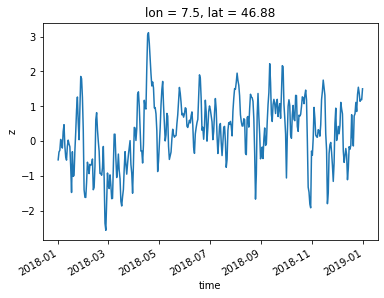

In [54]:
data.z.sel(lon=7.5, lat=46.875, time="2018").plot()

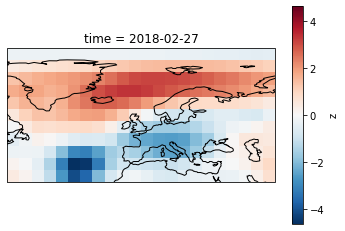

In [59]:
time = '2018-2-27'

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
data.z.sel(time=time).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r')

In [56]:
# save to disk as netcdf
data.to_netcdf(f'{DATADIR}z500/z500_anom_daily_1979-2021_5.625.nc')

## T2M (Surface temperature)

In [60]:
# Load data
DATADIR = '/home/steidani/windows/data/ParetoBoost/'  # Location of ERA5 dataset at 1.875° resolution, hourly from 1979 to 2021

# t2m
data = xr.open_mfdataset(f'{DATADIR}t2m/2m_temperature*.nc', combine='by_coords')
# land sea mask
mask = xr.open_mfdataset(f'{DATADIR}constants/constants_1.875.nc', combine='by_coords')

In [61]:
# change coordinate names
if 'latitude' in data.coords:
    data = data.rename({'latitude': 'lat', 'longitude': 'lon'})

# mask out ocean (less than 50% of the grid cell is land)
data = data.where(mask.lsm.values > 0.5)

# data.t2m.sel(time="2018-02-27T12").plot()

In [62]:
# daily mean
data = data.resample(time='1D').mean()

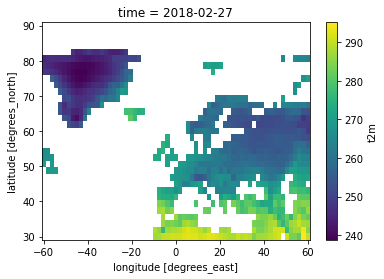

In [63]:
data.t2m.sel(time="2018-02-27").plot()

In [64]:
# running window
window = 31
groupby = "dayofyear"

# mean
data_mean = data.sel(time=slice("1979-01-01", "2000-12-31")).groupby('time' + '.' + groupby).mean('time')
data_mean = data_mean.chunk({'dayofyear': None})
# add periodicity
data_mean = data_mean.pad(**{groupby:window}, mode='wrap')
# rolling mean
data_mean = data_mean.rolling(**{groupby:window}, center=True).mean()
# remove periodicity
data_mean = data_mean.isel(**{groupby:slice(window,-window)})


# std
data_std = data.sel(time=slice("1979-01-01", "2000-12-31")).groupby('time' + '.' + groupby).std('time')
data_std = data_std.chunk({'dayofyear': None})
# add periodicity
data_std = data_std.pad(**{groupby:window}, mode='wrap')
# rolling mean
data_std = data_std.rolling(**{groupby:window}, center=True).mean()
# remove periodicity
data_std = data_std.isel(**{groupby:slice(window,-window)})


In [65]:
# normalize data
data = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    data.groupby('time' + '.' + groupby),
    data_mean,
    data_std,
    dask = 'allowed', vectorize = True,
)

In [66]:
# remove coordinate "dayofyear"
data = data.drop("dayofyear")

/home/steidani/miniconda3/envs/paretoboost/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


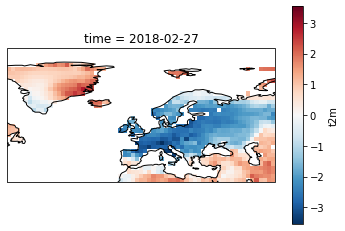

In [67]:
time = '2018-2-27'

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
data.t2m.sel(time=time).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r')

In [46]:
# save to disk as netcdf
data.to_netcdf(f'{DATADIR}t2m/t2m_anom_land_daily_1979-2021_1.875.nc')

/home/steidani/miniconda3/envs/paretoboost/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Target region for calculating extremes

Target region should contain large population density: see https://www.researchgate.net/figure/Population-density-Europe-2020-NUTS-3_fig1_355163326

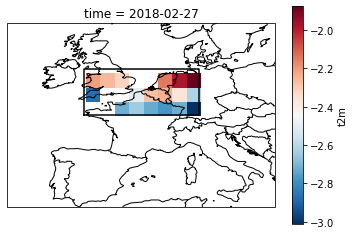

In [78]:
import cartopy.feature as cf

time = '2018-2-27'

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.set_extent([-15, 20, 36, 60], crs=ccrs.PlateCarree())
data.t2m.sel(time=time, lon=slice(-5,10), lat=slice(54,48)).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r')

lons = [-5,10]
lats = [48,54]
x = [lons[0], lons[1], lons[1], lons[0], lons[0]]
y = [lats[0], lats[0], lats[1], lats[1], lats[0]]
ax.plot(x, y, transform=ccrs.PlateCarree(), color='black')

In [79]:
data = data.sel(lon=slice(-5,10), lat=slice(54,48))

In [87]:
#data = data.dropna(dim="lon", how="all").dropna(dim="lat", how="all")

/home/steidani/miniconda3/envs/paretoboost/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/steidani/miniconda3/envs/paretoboost/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [88]:
# save to disk as netcdf
data.to_netcdf(f'{DATADIR}t2m/target_t2m_anom_land_daily_1979-2021_1.875.nc')

/home/steidani/miniconda3/envs/paretoboost/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
